In [2]:
import sys
print(sys.version)
print(sys.version_info)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


In [3]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# 第四章：MNIST数据集的训练

MNIST数据集是一个非常经典的用来训练手写数字的训练集，fastai里面包含了手写数字3和手写数字7的分类图片

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('C:/Users/94323/.fastai/data/mnist_sample')

In [5]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

path.ls()这个函数是用来查看路径下的文件和文件夹的，是fastai特有的函数而不是pathlib中的函数,另外在jupyter notebook中，可以在函数后面加上一个？，来查看函数所在的包和一些参数使用信息，例如：

In [6]:
path.ls?

Signature: path.ls(n_max=None, file_type=None, file_exts=None)
Docstring: Contents of path as a list
File:      c:\users\94323\anaconda3\lib\site-packages\fastcore\xtras.py
Type:      method


如果在使用doc()函数就可以看到你想查询函数的文档了，例如：

In [7]:
doc(path.ls)

接下来将文件内的内容排序，然后看看threes这个数组里的第一张是什么

In [8]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [9]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [10]:
type(im3)

PIL.PngImagePlugin.PngImageFile

我们可以看到im3是一个PIL库的PngImageFile对象，这个库是目前最流行的python对象处理库，同时，在pytorch库中tensor可以替代np中的array函数的功能，而且通过GPU计算能使得矩阵运算更加高速。

In [11]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


课程这里使用了一个很巧妙的方式来识别数字3和数字7，将这些图片上每个像素的值加起来，然后平均，就能得到数字3较为理想的平均值，之后拿到一张图片判断，也是将其像素化之后计算像素的平均值，看看是不是和3比较接近。数字7同理。

In [12]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

这段代码将3和7文件夹中的所有图片都打开，并将其向量化

In [13]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

由于seven_tensors这个变量是个数组，用stack函数将其转变为一个三维向量，同时由于原图片是属于0-255区间的，/255是将其转换成0-1区间

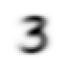

In [14]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

这里不能直接用stacked_threes.mean()的方式来求得平均值，这会将所有维度上的值进行计算，我们这里只需要计算第一维的数据的平均值，使用的是stacked_threes.mean(0)这个方式，0是第一个索引

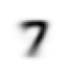

In [15]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

(tensor(0.1114), tensor(0.2021))

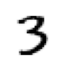

In [16]:
a_3 = stacked_threes[1]
show_image(a_3);

dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr



In [17]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

So，接下来我们要挑个幸运观众来验证一下训练结果，比如3数据集中的第二个元素

这里有一点比较重要，就是我们不能直接用样本减掉均值，因为这样会出现负数，在接下来的时候会很讨厌，有两种方法将这个负号清除掉，一种是调用绝对值函数（得到的误差称为L1 norm），另一种是将其平方之后再开根（得到的误差称为L2 norm 或者RMSE），

In [18]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

## 梯度下降（GD）和随机梯度下降（SGD）的区别

梯度下降使用了整个数据集进行计算，而随机梯度下降是使用划分成批次的数据进行计算，相当于使用样本来估计整体，这样在原始矩阵很大的情况下能够快一点得到收敛结果

## Sigmoid函数

这个函数长这样：

In [19]:
def sigmoid(x): return 1/(1+torch.exp(-x))

将其画出来则长这样：

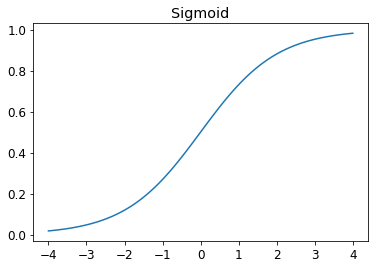

In [20]:
plot_function(torch.sigmoid, title="Sigmoid",min=-4,max=4)

这个函数和他类似的函数有个统一的名字：激活函数，目的是能够把一些非线性的函数转换成线性的函数，方便计算损失。其实就是个映射关系，把原函数的坐标轴上的离散数据转换到一个像sigmoid这样的函数上面，这样函数就有了连续性。

这是一个基本的神经网络的定义：

In [21]:
def simple_net(xb): 
    res = xb@w1 + b1                #第一个线性函数
    res = res.max(tensor(0.0))      #将第一个线性函数得到的结果转成自然数（负数变0）
    res = res@w2 + b2               #结果进入第二个线性函数
    return res

In [22]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

这样的话，原来的28*28的矩阵就被降维成了1维矩阵。

另外，这个res.max()函数就是常说的修正线性单元，也称ReLU,这个函数长成下面这个样子

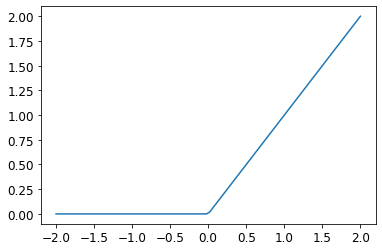

In [23]:
plot_function(F.relu)

为啥要有这样一个函数呢，假设我们把这个函数从定义中拿掉，原来的定义就变成了将一个y=ax+b的结果整理到另外一个y=ax+b中去，有点像

y1 = ax1 + b
z1 = cy1 + d

这个样子的式子可以整理成一个线性方程，只要通过修改系数和偏差

z1 = Ax + b

所以叠加层数实际上是一个没用的操作。加上了激活函数之后，只要层数够多，函数就会变成万能函数逼近器。像这样把一个函数的结果放到下一个函数中去的办法叫函数复合function composition，pytorch提供了一个整合这样线性层函数复合的类，叫sequential类，具体例子如下：


In [24]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)         #线性层的头尾得一样
)

## SGD的优化器建立

首先是pytorch中有一个nn.linear类，可以做到初始化参数和替代线性函数y=w@x+b的作用

In [25]:
linear_model=nn.Linear(28*28,1)

所以权重矩阵w和偏差b都成了这个模型中的一个参数

In [26]:
w,b=linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

可以看到这个是一个权重矩阵有784维度和一个偏差b，接下来我们要做的就是创建一个类

In [27]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr  #构造函数，类有两个成员，参数和学习率，分别初始化

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr            #迭代

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None                              #将grad初始化

这样的话训练循环就可以变成这样

In [28]:
def train_epoch(model):                                     #模型训练
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [29]:
def calc_grad(xb, yb, model):                               #计算损失
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [30]:
def validate_epoch(model):                                  #验证函数
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [31]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [32]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [33]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape


valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))


valid_dl = DataLoader(valid_dset, batch_size=256)
lr=1
opt = BasicOptim(linear_model.parameters(), lr)
validate_epoch(linear_model)

0.5202

In [34]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [35]:
dset = list(zip(train_x,train_y))

dl = DataLoader(range(15), batch_size=5, shuffle=True)
list(dl)
dl = DataLoader(dset, batch_size=256)
ds = L(enumerate(string.ascii_lowercase))

list(ds)

[(0, 'a'),
 (1, 'b'),
 (2, 'c'),
 (3, 'd'),
 (4, 'e'),
 (5, 'f'),
 (6, 'g'),
 (7, 'h'),
 (8, 'i'),
 (9, 'j'),
 (10, 'k'),
 (11, 'l'),
 (12, 'm'),
 (13, 'n'),
 (14, 'o'),
 (15, 'p'),
 (16, 'q'),
 (17, 'r'),
 (18, 's'),
 (19, 't'),
 (20, 'u'),
 (21, 'v'),
 (22, 'w'),
 (23, 'x'),
 (24, 'y'),
 (25, 'z')]

In [36]:
train_model(linear_model, 20)

0.4932 0.7412 0.8667 0.9194 0.9365 0.9512 0.959 0.9638 0.9658 0.9678 0.9697 0.9721 0.9741 0.9751 0.9761 0.977 0.9775 0.978 0.9785 0.9785 

上面的这些内容fastai都写好了，封装在SGD方法里，简单说就是。

In [37]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.79 0.8525 0.915 0.9341 0.9482 0.9575 0.9629 0.9658 0.9673 0.9692 0.9717 0.9741 0.9751 0.9761 0.9775 0.9775 0.9775 0.9785 0.9785 

另外learner类也能完成上面所有的过程，求解器和模型都封装好了在这个类里面，调用他的构造函数就能自动搞定。

In [38]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

调用learn.fit函数就可以进行模拟了

In [114]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.016778,0.037613,0.967615,00:00
1,0.016469,0.035276,0.969578,00:00
2,0.016143,0.033394,0.971541,00:00
3,0.015823,0.031841,0.973503,00:00
4,0.015527,0.030535,0.974485,00:00
5,0.015259,0.029422,0.975957,00:00
6,0.015022,0.028464,0.976938,00:00
7,0.014811,0.027632,0.977429,00:00
8,0.014624,0.026906,0.977920,00:00
9,0.014455,0.026265,0.978410,00:00


一般来说，层次越多的模型，学习率就应该越小。因为一般层次越多，曲线会越陡峭。

In [39]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.289997,0.416602,0.504416,00:00
1,0.139187,0.217227,0.819921,00:00
2,0.077946,0.110834,0.921492,00:00
3,0.051940,0.075958,0.941609,00:00
4,0.039816,0.059922,0.956330,00:00
5,0.033563,0.050830,0.963690,00:00
6,0.029928,0.045051,0.965162,00:00
7,0.027539,0.041075,0.965653,00:00
8,0.025803,0.038160,0.968106,00:00
9,0.024449,0.035923,0.969087,00:00


这里用了两层的模型去做训练，同时可以看到学习率变成了0.1，然后把他画出来

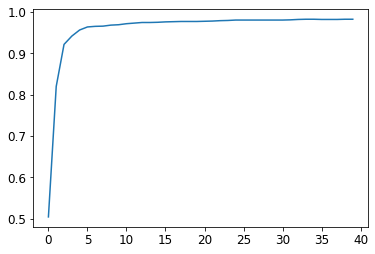

In [40]:
plt.plot(L(learn.recorder.values).itemgot(2));   #这里的itemgot函数是获得上面表的第三列的内容（表隐藏了）

另外，如果想看一个模型的具体构建的时候，使用.model成员查看。

In [41]:
learn.model

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [45]:
m = learn.model
w,b= m[0].parameters()
w,b

(Parameter containing:
 tensor([[ 0.0164,  0.0206,  0.0332,  ...,  0.0046,  0.0324, -0.0225],
         [ 0.0189,  0.0112,  0.0272,  ..., -0.0108,  0.0005, -0.0311],
         [-0.0185,  0.0332,  0.0354,  ...,  0.0058,  0.0176,  0.0184],
         ...,
         [ 0.0317,  0.0264,  0.0229,  ..., -0.0067,  0.0031, -0.0028],
         [-0.0035, -0.0148, -0.0338,  ..., -0.0102, -0.0287,  0.0081],
         [-0.0006, -0.0294,  0.0278,  ..., -0.0053,  0.0294, -0.0209]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0344, -0.0239,  0.0594, -0.0028, -0.0254, -0.0185,  0.0129,  0.1623,  0.0397, -0.0641, -0.0372,  0.0399,  0.0070, -0.0210,  0.0932,  0.0859,  0.0310, -0.0252,  0.1844,  0.0035, -0.0010,
          0.0118,  0.0073,  0.0461,  0.0753, -0.0301, -0.0071, -0.0119,  0.0124,  0.0591], requires_grad=True))

通过parameters()函数就可以得到具体层数的具体参数。

<AxesSubplot:>

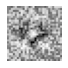

In [46]:
show_image(w[0].view(28,28))

In [48]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

RuntimeError: DataLoader worker (pid(s) 16736, 25516, 16800, 4628, 12580, 23652, 17360, 11180) exited unexpectedly